# Import statements

In [46]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import sklearn
import random
import os,sys

# import keras
import keras
from keras import backend as K
backend_keras = keras.backend.backend()
print("keras is using", backend_keras, "as the backend")
from keras.layers import Input, Flatten, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model, load_model, Sequential

# opt
from keras.optimizers import SGD, Nadam, Adamax, Adam, Adadelta, Adagrad, RMSprop


keras is using tensorflow as the backend


# Load esc frac data and labels
These are the ones which have been created with the keras notebook

In [2]:
f = os.listdir()
f.sort()
for i in f: print(i)

.ipynb_checkpoints
CNN3_classify_redshift_with_autoencoder.ipynb
CNN4_classify_esc_frac_direct_cnn.ipynb
CNN5_classify_esc_frac_with_autoencoder.ipynb
CNN6_classify_redshift_direct_cnn.ipynb
big_mix_data_6528.npy
big_mix_labels_6528.npy
data_test.npy
data_train.npy
data_val.npy
figures
keras_arch_05.0_with_encoder_esc_predict.model
keras_arch_05.1_with_encoder_esc_predict.model
labels_test.npy
labels_train.npy
labels_val.npy
preprocessing.ipynb
trained models
training_perf_250_arch_03.0_pred_redshift_with_encoder.png
training_perf_250_arch_03.1_pred_redshift_with_encoder.png


In [3]:
# load data
x_train_raw = np.load("data_train.npy",allow_pickle=True)
x_val_raw = np.load("data_val.npy")
x_test_raw = np.load("data_test.npy")

# load labels
labels_train = np.load("labels_train.npy",allow_pickle=True)
labels_val = np.load("labels_val.npy",allow_pickle=True)
labels_test = np.load("labels_test.npy",allow_pickle=True)

# we only care about the redshift labels here
lab_esc_train = np.array([i[0] for i in labels_train])
lab_esc_val = np.array([i[0] for i in labels_val])
lab_esc_test = np.array([i[0] for i in labels_test])

print("shapes :", x_train_raw.shape, x_val_raw.shape, x_test_raw.shape)
print("more shape :", lab_esc_train.shape, lab_esc_val.shape, lab_esc_test.shape)

shapes : (4896, 200, 200, 1) (652, 200, 200, 1) (980, 200, 200, 1)
more shape : (4896, 12) (652, 12) (980, 12)


# Apply Autoencoder
## first load the autoencoder

In [4]:
os.listdir("../../Auto-Encoder Training/")
autoencoder = load_model("../../Auto-Encoder Training/autoencoder_adam_95.model")

In [5]:
#autoencoder.summary()
encoder = Model(autoencoder.input, autoencoder.layers[-8].output)
encoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200, 200, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 200, 200, 16)      160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 100, 100, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 100, 100, 8)       1160      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 50, 50, 8)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 50, 50, 8)         584       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 25, 25, 8)         0   

In [26]:
x_train = encoder.predict(x_train_raw)
x_val = encoder.predict(x_val_raw)
x_test = encoder.predict(x_test_raw)

# Define the CNN architecture

In [34]:
classifier = Sequential()

# extract features
classifier.add(Conv2D(8, (3,3), input_shape=(25,25,8),
                     activation='relu', padding='valid'))
# reduce dimensionality, keep most important info
classifier.add(MaxPooling2D(pool_size=(2,2)))

# add a second layer, again with no padding
classifier.add(Conv2D(4, (3,3), activation='relu', padding='valid'))

# pool again
#classifier.add(MaxPooling2D(pool_size=(2,2)))

# here i flatten and then guess the class
classifier.add(Flatten())

# fully connected layers ensures connections to all activations 
# in previous layers

classifier.add(Dense(units=12, activation='softmax'))

# Alternative Architecture

In [24]:
classifier = Sequential()

# extract features
classifier.add(Conv2D(32, (3,3), input_shape=(25,25,8),
                     activation='relu', padding='same'))
# reduce dimensionality, keep most important info
classifier.add(MaxPooling2D(pool_size=(2,2)))

# extract features
#classifier.add(Conv2D(16, (3,3), input_shape=(25,25,8),
                     activation="relu", padding='same'))

# downsample
classifier.add(MaxPooling2D(pool_size=(2,2)))

classifier.add(Flatten())

classifier.add(Dense(units=12, activation='softmax'))

# Hyper params + compile network

In [35]:
# SGD, Nadam, Adamax, Adam, Adadelta, Adagrad, RMSprop

opt = RMSprop(learning_rate=0.001, rho=0.9)

classifier.compile(optimizer=opt,
                   loss='categorical_crossentropy',
                   metrics=["accuracy"])
print("printing summary of model")
classifier.summary()

printing summary of model
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 23, 23, 8)         584       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 11, 11, 8)         0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 9, 9, 4)           292       
_________________________________________________________________
flatten_7 (Flatten)          (None, 324)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 12)                3900      
Total params: 4,776
Trainable params: 4,776
Non-trainable params: 0
_________________________________________________________________


# Train the network

In [36]:
print(x_train.shape, lab_esc_train.shape)

(4896, 25, 25, 8) (4896, 12)


# Display netowrk stats and save plots

In [43]:
EPOCHS = 450

H = classifier.fit(x_train, lab_esc_train,
                  epochs = EPOCHS,
                  batch_size = 128,
                  shuffle = True,
                  validation_data=(x_val, lab_esc_val))

Train on 4896 samples, validate on 652 samples
Epoch 1/450
4896/4896 [==============================] - 1s 253us/step - loss: 1.9319 - accuracy: 0.2878 - val_loss: 2.3601 - val_accuracy: 0.1840
Epoch 2/450
4896/4896 [==============================] - 1s 254us/step - loss: 1.9310 - accuracy: 0.2947 - val_loss: 2.2678 - val_accuracy: 0.1641
Epoch 3/450
4896/4896 [==============================] - 1s 281us/step - loss: 1.9313 - accuracy: 0.2884 - val_loss: 2.3795 - val_accuracy: 0.1488
Epoch 4/450
4896/4896 [==============================] - 1s 196us/step - loss: 1.9310 - accuracy: 0.2878 - val_loss: 2.1985 - val_accuracy: 0.1764
Epoch 5/450
4896/4896 [==============================] - 1s 242us/step - loss: 1.9211 - accuracy: 0.3017 - val_loss: 2.4369 - val_accuracy: 0.1840
Epoch 6/450
4896/4896 [==============================] - 1s 231us/step - loss: 1.9419 - accuracy: 0.2857 - val_loss: 2.1936 - val_accuracy: 0.1825
Epoch 7/450
4896/4896 [==============================] - 2s 343us/step 

4896/4896 [==============================] - 1s 227us/step - loss: 1.8968 - accuracy: 0.3011 - val_loss: 2.3410 - val_accuracy: 0.1748
Epoch 57/450
4896/4896 [==============================] - 1s 227us/step - loss: 1.9078 - accuracy: 0.3137 - val_loss: 2.3098 - val_accuracy: 0.1656
Epoch 58/450
4896/4896 [==============================] - 1s 228us/step - loss: 1.9263 - accuracy: 0.2913 - val_loss: 2.3313 - val_accuracy: 0.1718
Epoch 59/450
4896/4896 [==============================] - 1s 241us/step - loss: 1.8919 - accuracy: 0.3066 - val_loss: 2.2333 - val_accuracy: 0.1687
Epoch 60/450
4896/4896 [==============================] - 1s 245us/step - loss: 1.8951 - accuracy: 0.3004 - val_loss: 2.2831 - val_accuracy: 0.1856
Epoch 61/450
4896/4896 [==============================] - 1s 250us/step - loss: 1.8929 - accuracy: 0.3033 - val_loss: 2.4388 - val_accuracy: 0.1610
Epoch 62/450
4896/4896 [==============================] - 1s 273us/step - loss: 1.9179 - accuracy: 0.2935 - val_loss: 2.4210 

4896/4896 [==============================] - 1s 212us/step - loss: 1.8788 - accuracy: 0.3096 - val_loss: 2.3239 - val_accuracy: 0.1672
Epoch 112/450
4896/4896 [==============================] - 1s 207us/step - loss: 1.8761 - accuracy: 0.3062 - val_loss: 2.4267 - val_accuracy: 0.1442
Epoch 113/450
4896/4896 [==============================] - 1s 210us/step - loss: 1.8748 - accuracy: 0.3180 - val_loss: 2.5415 - val_accuracy: 0.1641
Epoch 114/450
4896/4896 [==============================] - 1s 212us/step - loss: 1.8857 - accuracy: 0.2990 - val_loss: 2.2223 - val_accuracy: 0.1963
Epoch 115/450
4896/4896 [==============================] - 1s 214us/step - loss: 1.8840 - accuracy: 0.3092 - val_loss: 2.2888 - val_accuracy: 0.1840
Epoch 116/450
4896/4896 [==============================] - 1s 209us/step - loss: 1.8743 - accuracy: 0.3092 - val_loss: 2.3443 - val_accuracy: 0.1580
Epoch 117/450
4896/4896 [==============================] - 1s 212us/step - loss: 1.8732 - accuracy: 0.3076 - val_loss: 2

4896/4896 [==============================] - 1s 224us/step - loss: 1.8623 - accuracy: 0.3170 - val_loss: 2.1919 - val_accuracy: 0.2009
Epoch 167/450
4896/4896 [==============================] - 1s 218us/step - loss: 1.8624 - accuracy: 0.3105 - val_loss: 2.2038 - val_accuracy: 0.1825
Epoch 168/450
4896/4896 [==============================] - 1s 218us/step - loss: 1.8752 - accuracy: 0.3115 - val_loss: 2.2609 - val_accuracy: 0.1871
Epoch 169/450
4896/4896 [==============================] - 1s 218us/step - loss: 1.8575 - accuracy: 0.3231 - val_loss: 2.4020 - val_accuracy: 0.1564
Epoch 170/450
4896/4896 [==============================] - 1s 214us/step - loss: 1.8862 - accuracy: 0.3141 - val_loss: 2.3141 - val_accuracy: 0.1672
Epoch 171/450
4896/4896 [==============================] - 1s 218us/step - loss: 1.8626 - accuracy: 0.3192 - val_loss: 2.4028 - val_accuracy: 0.1626
Epoch 172/450
4896/4896 [==============================] - 1s 225us/step - loss: 1.8694 - accuracy: 0.3105 - val_loss: 2

4896/4896 [==============================] - 2s 323us/step - loss: 1.8358 - accuracy: 0.3205 - val_loss: 2.2186 - val_accuracy: 0.1856
Epoch 222/450
4896/4896 [==============================] - 1s 250us/step - loss: 1.8460 - accuracy: 0.3227 - val_loss: 2.3247 - val_accuracy: 0.1764
Epoch 223/450
4896/4896 [==============================] - 1s 216us/step - loss: 1.8455 - accuracy: 0.3143 - val_loss: 2.2160 - val_accuracy: 0.1764
Epoch 224/450
4896/4896 [==============================] - 1s 217us/step - loss: 1.8387 - accuracy: 0.3172 - val_loss: 2.1666 - val_accuracy: 0.2071
Epoch 225/450
4896/4896 [==============================] - 1s 211us/step - loss: 1.8363 - accuracy: 0.3145 - val_loss: 2.2114 - val_accuracy: 0.1994
Epoch 226/450
4896/4896 [==============================] - 1s 220us/step - loss: 1.8458 - accuracy: 0.3117 - val_loss: 2.3311 - val_accuracy: 0.1994
Epoch 227/450
4896/4896 [==============================] - 1s 213us/step - loss: 1.8382 - accuracy: 0.3174 - val_loss: 2

4896/4896 [==============================] - 1s 214us/step - loss: 1.8867 - accuracy: 0.3235 - val_loss: 2.2033 - val_accuracy: 0.1871
Epoch 277/450
4896/4896 [==============================] - 1s 222us/step - loss: 1.8305 - accuracy: 0.3207 - val_loss: 2.3313 - val_accuracy: 0.1856
Epoch 278/450
4896/4896 [==============================] - 1s 248us/step - loss: 1.8076 - accuracy: 0.3378 - val_loss: 2.1842 - val_accuracy: 0.1794
Epoch 279/450
4896/4896 [==============================] - 1s 246us/step - loss: 1.8452 - accuracy: 0.3182 - val_loss: 2.3079 - val_accuracy: 0.1871
Epoch 280/450
4896/4896 [==============================] - 1s 215us/step - loss: 1.8262 - accuracy: 0.3235 - val_loss: 2.1956 - val_accuracy: 0.2163
Epoch 281/450
4896/4896 [==============================] - 1s 270us/step - loss: 1.8422 - accuracy: 0.3272 - val_loss: 2.2302 - val_accuracy: 0.2009
Epoch 282/450
4896/4896 [==============================] - 1s 238us/step - loss: 1.8292 - accuracy: 0.3237 - val_loss: 2

4896/4896 [==============================] - 1s 257us/step - loss: 1.8159 - accuracy: 0.3246 - val_loss: 2.3263 - val_accuracy: 0.1948
Epoch 332/450
4896/4896 [==============================] - 1s 238us/step - loss: 1.8121 - accuracy: 0.3278 - val_loss: 2.1596 - val_accuracy: 0.1933
Epoch 333/450
4896/4896 [==============================] - 1s 243us/step - loss: 1.8484 - accuracy: 0.3272 - val_loss: 2.2358 - val_accuracy: 0.1948
Epoch 334/450
4896/4896 [==============================] - 1s 234us/step - loss: 1.7989 - accuracy: 0.3366 - val_loss: 2.3927 - val_accuracy: 0.1687
Epoch 335/450
4896/4896 [==============================] - 1s 239us/step - loss: 1.8134 - accuracy: 0.3317 - val_loss: 2.2161 - val_accuracy: 0.2040
Epoch 336/450
4896/4896 [==============================] - 1s 234us/step - loss: 1.8211 - accuracy: 0.3250 - val_loss: 2.3202 - val_accuracy: 0.2101
Epoch 337/450
4896/4896 [==============================] - 1s 242us/step - loss: 1.8040 - accuracy: 0.3286 - val_loss: 2

4896/4896 [==============================] - 2s 493us/step - loss: 1.7924 - accuracy: 0.3342 - val_loss: 2.2066 - val_accuracy: 0.2101
Epoch 387/450
4896/4896 [==============================] - 2s 394us/step - loss: 1.7974 - accuracy: 0.3331 - val_loss: 2.2293 - val_accuracy: 0.1902
Epoch 388/450
4896/4896 [==============================] - 2s 345us/step - loss: 1.7943 - accuracy: 0.3321 - val_loss: 2.2571 - val_accuracy: 0.1994
Epoch 389/450
4896/4896 [==============================] - 2s 504us/step - loss: 1.7994 - accuracy: 0.3327 - val_loss: 2.3818 - val_accuracy: 0.1856
Epoch 390/450
4896/4896 [==============================] - 2s 504us/step - loss: 1.7879 - accuracy: 0.3337 - val_loss: 2.1842 - val_accuracy: 0.1933
Epoch 391/450
4896/4896 [==============================] - 3s 531us/step - loss: 1.8037 - accuracy: 0.3272 - val_loss: 2.2457 - val_accuracy: 0.1994
Epoch 392/450
4896/4896 [==============================] - 2s 399us/step - loss: 1.8476 - accuracy: 0.3250 - val_loss: 2

4896/4896 [==============================] - 2s 443us/step - loss: 1.7736 - accuracy: 0.3421 - val_loss: 2.2646 - val_accuracy: 0.1887
Epoch 442/450
4896/4896 [==============================] - 3s 517us/step - loss: 1.7931 - accuracy: 0.3346 - val_loss: 2.2505 - val_accuracy: 0.1963
Epoch 443/450
4896/4896 [==============================] - 2s 496us/step - loss: 1.7811 - accuracy: 0.3354 - val_loss: 2.4232 - val_accuracy: 0.1810
Epoch 444/450
4896/4896 [==============================] - 2s 485us/step - loss: 1.7747 - accuracy: 0.3407 - val_loss: 2.2355 - val_accuracy: 0.2101
Epoch 445/450
4896/4896 [==============================] - 2s 341us/step - loss: 1.7838 - accuracy: 0.3339 - val_loss: 2.2257 - val_accuracy: 0.2117
Epoch 446/450
4896/4896 [==============================] - 1s 269us/step - loss: 1.7760 - accuracy: 0.3423 - val_loss: 2.2551 - val_accuracy: 0.1887
Epoch 447/450
4896/4896 [==============================] - 1s 272us/step - loss: 1.7856 - accuracy: 0.3384 - val_loss: 2

# Evaluate the netowrk - display network stats and save plots

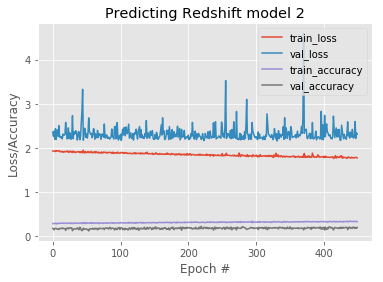

In [44]:
# plot the training loss and accuracy for each epoch
N = np.arange(0, EPOCHS)
plt.figure()
plt.style.use("ggplot")
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.plot(N, H.history["accuracy"], label="train_accuracy")
plt.plot(N, H.history["val_accuracy"], label="val_accuracy")
plt.title("Predicting Redshift model 2")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig("training_perf_250_arch_03.4.75_pred_redshift_with_encoder.png")
plt.show()

# Save the weights

In [45]:
classifier.save("keras_arch_05.4.75_with_encoder_esc_predict.model")

# Make prediction

In [23]:
pred  = classifier.predict(x_test)
print(pred.shape, lab_esc_test.shape)
l = len(pred)

(980, 12) (980, 12)


In [29]:
ri,wr=0,0
for i in range(len(pred)):
    a = list(pred[i]).index(max(pred[i]))
    b = list(lab_esc_test[i]).index(1)
    if a==b: ri+=1
    else: wr +=1
print(100.0*ri / (ri+wr))

13.673469387755102


In [30]:
print("percent correctly classified\n",
     100.0*float(right)/count)

NameError: name 'right' is not defined